Load data

In [3]:
import numpy as np
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# Path
DATA_DIR = "../Data"

# Constants
BATTERY_CAP = 37725
DEPOT_IDX = 0

# Hyperparameters
SEARCH_TIME_LIMIT_S = 600
MAX_VEHICLES = 500
VEHICLE_FIXED_COST = 50000  # Cost per mission

# ---- Load arrays ----
distance_matrix = np.load(f"{DATA_DIR}/distance_matrix.npy")
predecessors = np.load(f"{DATA_DIR}/predecessors.npy")
points_lon_lat = np.load(f"{DATA_DIR}/points_lat_long.npy")
asset_indexes = np.load(f"{DATA_DIR}/asset_indexes.npy")
photo_indexes = np.load(f"{DATA_DIR}/photo_indexes.npy")

# Process indexes into lists
def as_index_list(idx_array, N):
    arr = np.array(idx_array).astype(int).ravel()
    if arr.size == 2 and arr[0] <= arr[1]:
        start, end = arr.tolist()
        start = max(0, min(start, N-1))
        end   = max(0, min(end,   N-1))
        return list(range(start, end + 1))
    # Otherwise treat it as a list of indices
    out = [int(x) for x in arr.tolist() if 0 <= int(x) < N]
    return sorted(list(set(out)))

N = distance_matrix.shape[0]

# Build photo node list
PHOTO_NODES = as_index_list(photo_indexes, N)
assert 0 <= DEPOT_IDX < N, "Depot index 0 is out of range for the distance matrix"

print(f"N nodes in matrix: {N}")
print(f"#photo nodes to visit: {len(PHOTO_NODES)} (e.g., first 5: {PHOTO_NODES[:5]})")

N nodes in matrix: 2779
#photo nodes to visit: 2779 (e.g., first 5: [0, 1, 2, 3, 4])


Filter out nonPhoto Waypoints

In [4]:
# Map
working_indexes = [DEPOT_IDX] + PHOTO_NODES
R = len(working_indexes)

# Build reduced matrix
reduced = np.zeros((R, R), dtype=np.int32)
for i, gi in enumerate(working_indexes):
    reduced[i, :] = distance_matrix[gi, working_indexes].astype(np.int64)

print(f"Reduced matrix size: {reduced.shape} (Depot + Photos)")

# Check wich photos are reachable under battery constraint
depot_r = 0
reachable_mask = [True]
unreachable_photos = []

for i in range(1, R):
    there = int(reduced[depot_r, i])
    back  = int(reduced[i, depot_r])
    if there + back <= BATTERY_CAP:
        reachable_mask.append(True)
    else:
        reachable_mask.append(False)
        unreachable_photos.append(working_indexes[i])

print(f"Unreachable photos: {len(unreachable_photos)}")
if unreachable_photos:
    print(f" Examples: {unreachable_photos[:5]}")


Reduced matrix size: (2780, 2780) (Depot + Photos)
Unreachable photos: 0


Solve VRP with the battery restriction

In [5]:
import time

def optimize_vrp(reduced_matrix, battery_cap, max_vehicles, vehicle_fixed_cost, 
                 time_limit_s, stop_on_first_solution=True):
    R = reduced_matrix.shape[0]
    manager = pywrapcp.RoutingIndexManager(R, max_vehicles, 0)
    routing = pywrapcp.RoutingModel(manager)

    # Transit cost from the reduced matrix
    def transit_cb(from_index, to_index):
        i = manager.IndexToNode(from_index)
        j = manager.IndexToNode(to_index)
        return int(reduced_matrix[i][j])
    
    transit_idx = routing.RegisterTransitCallback(transit_cb)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_idx)

    # Battery cap
    routing.AddDimension(
        transit_idx, 0,
        int(battery_cap), # max distance per drone
        True, "Distance"
    )
    distance_dim = routing.GetDimensionOrDie("Distance")

    # Encourage fewer missions
    routing.SetFixedCostOfAllVehicles(int(vehicle_fixed_cost))
    # Search parameters
    params = pywrapcp.DefaultRoutingSearchParameters()
    # Simple fast first solution
    params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.SAVINGS

    params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    params.time_limit.seconds = int(time_limit_s)
    params.log_search = True

    # Stop at first solution found
    if stop_on_first_solution:
        params.solution_limit = 1

    # Print progress
    t0 = time.time()
    best_cost = {"val": None}

    def on_solution():
        # Callback on each new solution
        try:
            elapsed = time.time() - t0
            print(f"[{elapsed:6.1f}s] feasible solution found...", flush=True)
        except Exception as e:
            print(f"[callback warning] {e}", flush=True)

    routing.AddAtSolutionCallback(on_solution)

    solution = routing.SolveWithParameters(params)
    return manager, routing, distance_dim, solution

# Try quick first feasible run
manager, routing, distance_dim, solution = optimize_vrp(
    reduced_matrix=reduced,
    battery_cap=BATTERY_CAP,
    max_vehicles=200,
    vehicle_fixed_cost=VEHICLE_FIXED_COST,
    time_limit_s=180,
    stop_on_first_solution=True
)

if not solution:
    print("No solution in quick run")
else:
    print("Found a solution in quick run")

[  23.6s] feasible solution found...
Found a solution in quick run


Extract Routes

In [6]:
routes_global = []  # list of missions | each mission is a list of GLOBAL node IDs (depot, photos, depot)
routes_reduced = []

for v in range(routing.vehicles()):
    idx = routing.Start(v)
    # skips vehicles that were not used
    if routing.IsEnd(solution.Value(routing.NextVar(idx))):
        continue
    
    r_red = []
    while not routing.IsEnd(idx):
        node_r = manager.IndexToNode(idx)
        r_red.append(node_r)
        idx = solution.Value(routing.NextVar(idx))
    r_red.append(manager.IndexToNode(idx))

    # map reduced global
    r_glob = [working_indexes[i] for i in r_red]
    routes_reduced.append(r_red)
    routes_global.append(r_glob)

print("missions extracted:", len(routes_global))
print("example mission (first 12 nodes):", routes_global[0][:12] if routes_global else None)


missions extracted: 9
example mission (first 12 nodes): [0, 0, 1, 1796, 1799, 1809, 2070, 2065, 2067, 2057, 2059, 2049]


In [7]:
# Mission length in feet
def mission_len(global_path):
    total = 0
    for a, b in zip(global_path[:-1], global_path[1:]):
        total += int(distance_matrix[a, b])
    return total

mission_lengths = [mission_len(path) for path in routes_global]
total_distance = sum(mission_lengths)

print(f"Total missions: {len(routes_global)}")
print(f"Total distance (feet): {total_distance}")
print(f"Average mission length (feet): {int(np.mean(mission_lengths)) if mission_lengths else 0}")
print(f"Max mission length (feet): {int(np.max(mission_lengths)) if mission_lengths else 0}")

# Battery check: every mission must be <= BATTERY_CAP
violations = [L for L in mission_lengths if L > BATTERY_CAP + 1e-6]
print("Battery violations:", len(violations))

# Coverage check: every photo must appear at least once in routes_global
visited = set()
for path in routes_global:
    # exclude depot on both ends
    for n in path[1:-1]:
        if n in set(PHOTO_NODES):
            visited.add(n)

missing = sorted(set(PHOTO_NODES) - visited)
duplicates = {}

from collections import Counter
cnt = Counter(n for path in routes_global for n in path if n in set(PHOTO_NODES))
for k,v in cnt.items():
    if v > 1:
        duplicates[k] = v

print(f"Photos required: {len(PHOTO_NODES)}")
print(f"Photos visited: {len(visited)}")
print(f"Missing: {len(missing)} (showing up to 10): {missing[:10]}")
print(f"Duplicates (>1): {len(duplicates)} (showing up to 10): {list(duplicates.items())[:10]}")


Total missions: 9
Total distance (feet): 332152
Average mission length (feet): 36905
Max mission length (feet): 37725
Battery violations: 0
Photos required: 2779
Photos visited: 2779
Missing: 0 (showing up to 10): []
Duplicates (>1): 1 (showing up to 10): [(0, 19)]


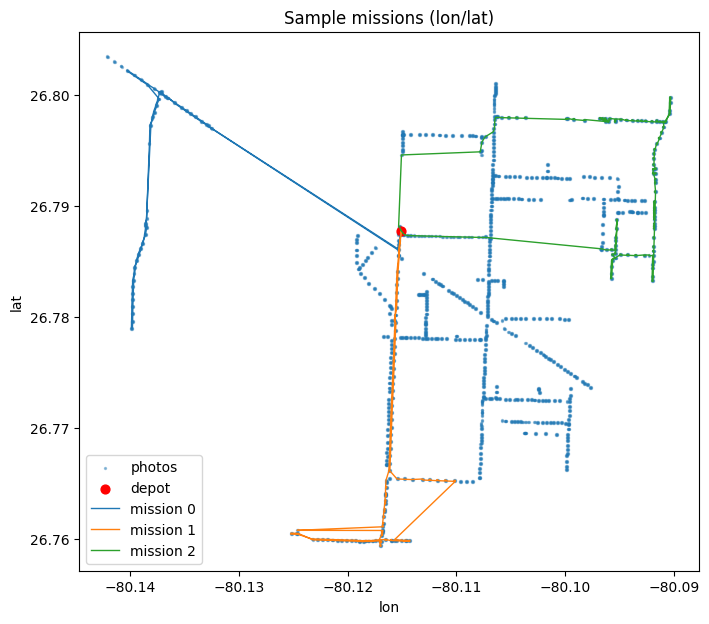

In [8]:
# Quick plot of some missions
import matplotlib.pyplot as plt

def plot_missions(sample_indices=(0,1,2)):
    plt.figure(figsize=(8,7))
    # plot photos
    pts = points_lon_lat
    xs = pts[:,0]; ys = pts[:,1]
    plt.scatter(xs[PHOTO_NODES], ys[PHOTO_NODES], s=2, alpha=0.4, label="photos")
    # plot depot
    plt.scatter([pts[DEPOT_IDX,0]],[pts[DEPOT_IDX,1]], c="red", s=40, label="depot")

    # draw a few example missions
    colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown"]
    for k, mi in enumerate(sample_indices):
        if mi >= len(routes_global): break
        path = routes_global[mi]
        xs_m = pts[path,0]; ys_m = pts[path,1]
        plt.plot(xs_m, ys_m, linewidth=1.0, label=f"mission {mi}", color=colors[k % len(colors)])
    plt.legend()
    plt.title("Sample missions (lon/lat)")
    plt.xlabel("lon"); plt.ylabel("lat")
    plt.show()

plot_missions((0,1,2))  # change which missions to show


Better qUAliTY? more OPTIMIZATION???

In [9]:
manager2, routing2, distance_dim2, solution2 = optimize_vrp(
    reduced_matrix=reduced,
    battery_cap=BATTERY_CAP,
    max_vehicles=MAX_VEHICLES,       # let it use up to this many missions if needed
    vehicle_fixed_cost=VEHICLE_FIXED_COST,
    time_limit_s=900,                 # try 15 minutes
    stop_on_first_solution=False      # keep improving until time is up
)

if solution2:
    print("Improve pass: solution found")
    # re-extract routes the same way (copy-paste 4A but use manager2/routing2/solution2)
    routes_global = []
    for v in range(routing2.vehicles()):
        idx = routing2.Start(v)
        if routing2.IsEnd(solution2.Value(routing2.NextVar(idx))):
            continue
        path = []
        while not routing2.IsEnd(idx):
            node_r = manager2.IndexToNode(idx)
            path.append(working_indexes[node_r])
            idx = solution2.Value(routing2.NextVar(idx))
        path.append(working_indexes[manager2.IndexToNode(idx)])
        routes_global.append(path)

    # recalc metrics (copy-paste 4B metric block)
    mission_lengths = [mission_len(p) for p in routes_global]
    print(f"Improve pass -> missions: {len(routes_global)}, total distance: {sum(mission_lengths)}")
else:
    print("Improve pass: no solution (unlikely if quick run succeeded)")


[  22.3s] feasible solution found...
[  22.4s] feasible solution found...
[  22.5s] feasible solution found...
[  22.5s] feasible solution found...
[  22.6s] feasible solution found...
[  22.6s] feasible solution found...
[  22.7s] feasible solution found...
[  22.8s] feasible solution found...
[  23.1s] feasible solution found...
[  23.2s] feasible solution found...
[  23.2s] feasible solution found...
[  23.3s] feasible solution found...
[  23.4s] feasible solution found...
[  23.4s] feasible solution found...
[  23.5s] feasible solution found...
[  23.5s] feasible solution found...
[  23.6s] feasible solution found...
[  23.6s] feasible solution found...
[  23.7s] feasible solution found...
[  23.7s] feasible solution found...
[  23.8s] feasible solution found...
[  23.8s] feasible solution found...
[  23.9s] feasible solution found...
[  24.1s] feasible solution found...
[  24.9s] feasible solution found...
[  25.0s] feasible solution found...
[  25.0s] feasible solution found...
[

THE OPTIMAL SOLUTION

Metrics + Plots

In [11]:
# === Metrics + Coverage ===
import numpy as np
from collections import Counter

def mission_len_feet(global_path, distM):
    return int(sum(int(distM[a, b]) for a, b in zip(global_path[:-1], global_path[1:])))

mission_lengths = [mission_len_feet(p, distance_matrix) for p in routes_global]
total_distance = int(sum(mission_lengths))
avg_distance = int(np.mean(mission_lengths)) if mission_lengths else 0
max_distance = int(np.max(mission_lengths)) if mission_lengths else 0

# Battery check
violations = [L for L in mission_lengths if L > BATTERY_CAP + 1e-6]

# Coverage: every photo must appear at least once
photo_set = set(PHOTO_NODES)
visited = set()
for path in routes_global:
    for n in path[1:-1]:   # ignore depot at ends
        if n in photo_set:
            visited.add(n)
missing = sorted(photo_set - visited)

# Duplicates (optional)
counts = Counter(n for path in routes_global for n in path if n in photo_set)
duplicates = {k: v for k, v in counts.items() if v > 1}

print(f"Total missions: {len(routes_global)}")
print(f"Total distance (ft): {total_distance}")
print(f"Avg mission (ft): {avg_distance}")
print(f"Max mission (ft): {max_distance}")
print(f"Battery violations: {len(violations)}")
print(f"Photos required: {len(photo_set)} | visited: {len(visited)} | missing: {len(missing)}")
if missing:
    print("Example missing:", missing[:10])
print(f"Photos visited >1 time: {len(duplicates)}")


Total missions: 8
Total distance (ft): 273079
Avg mission (ft): 34134
Max mission (ft): 37618
Battery violations: 0
Photos required: 2779 | visited: 2779 | missing: 0
Photos visited >1 time: 1


PROJECT_ROOT = c:\Users\Owner\OneDrive\Documents\PROJECTS\Hackathon\KDKR


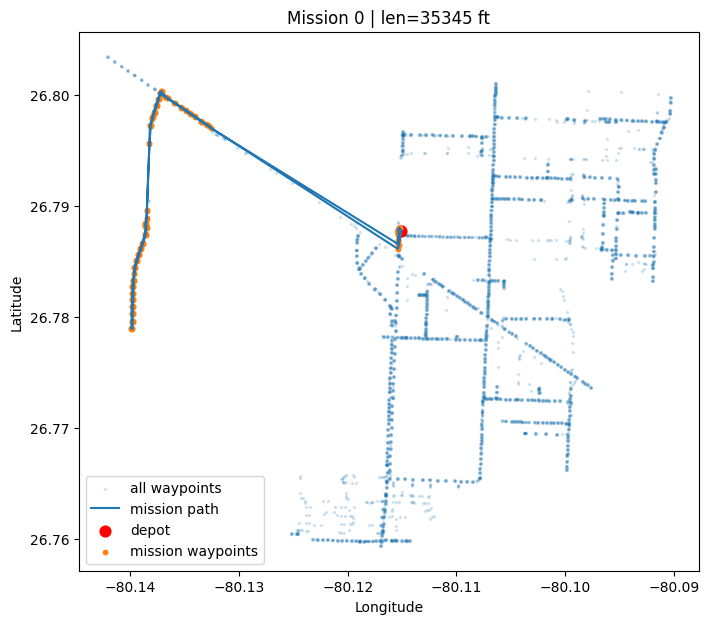

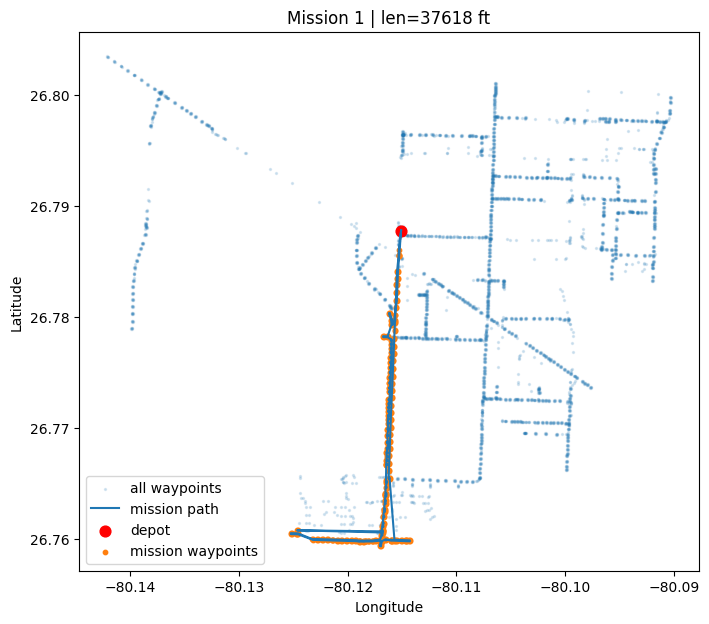

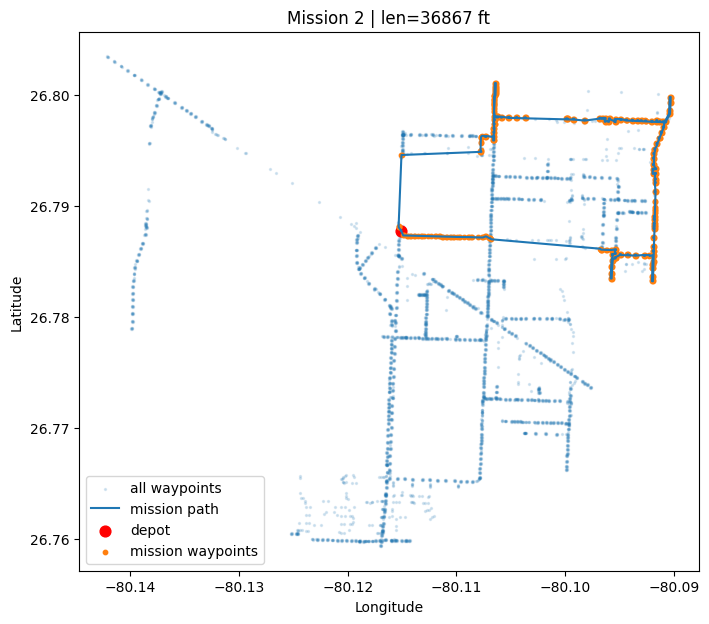

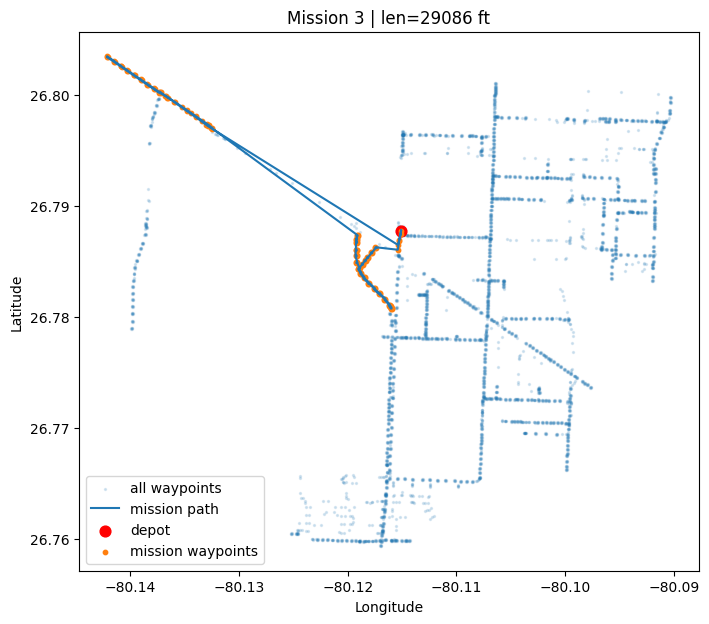

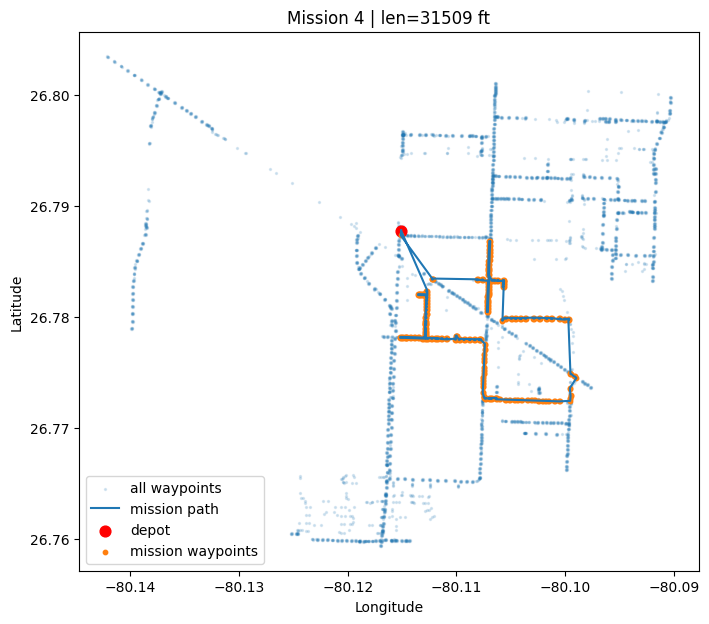

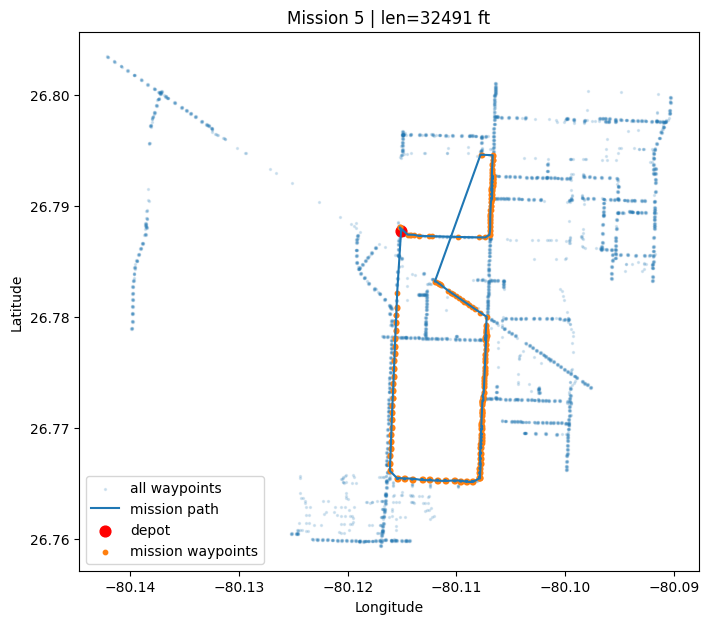

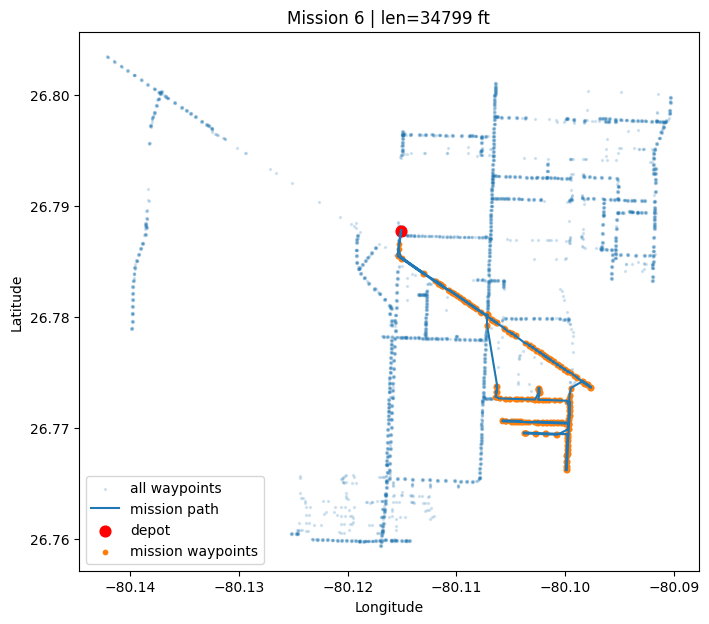

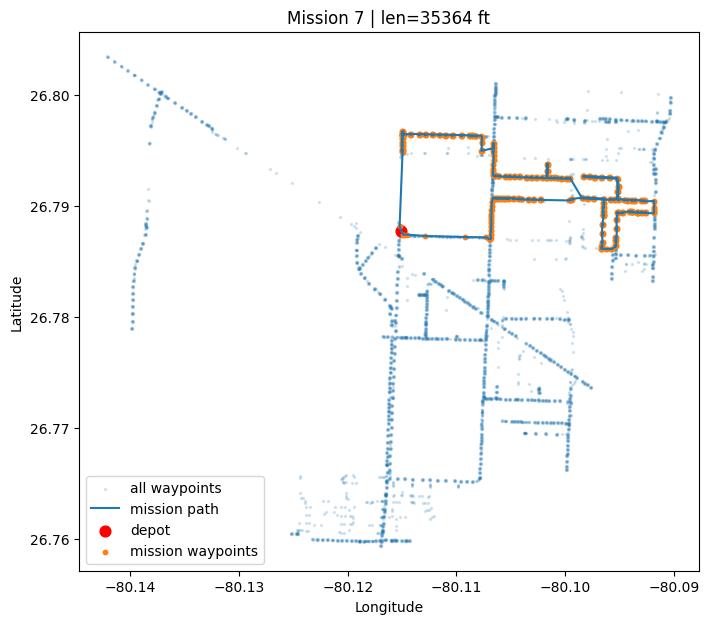

In [15]:
# If your notebook lives in KDKR/src, add the project root (KDKR/) to sys.path.
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent      # KDKR/
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT =", PROJECT_ROOT)

# Draw every mission. You only have 8, so this is fine.
from Visualization.plot_mission import plot_single_mission

for mi, path in enumerate(routes_global):
    plot_single_mission(
        points_lon_lat=points_lon_lat,
        mission_nodes_global=path,
        depot_idx=DEPOT_IDX,
        title=f"Mission {mi} | len={int(sum(int(distance_matrix[a,b]) for a,b in zip(path[:-1], path[1:])))} ft",
        save_path=None,   # set a filename to save instead of show
        show=True
    )


In [ ]:
# Save
PATHS_DIR = "../Optimized Paths"

np.save(f"{PATHS_DIR}/routes_global.npy", np.array(routes_global, dtype=object))
np.save(f"{PATHS_DIR}/mission_lengths_feet.npy", np.array(mission_lengths))
print("Saved routes_global.npy and mission_lengths_feet.npy")

Saved routes_global.npy and mission_lengths_feet.npy
